In [14]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from copy import deepcopy

In [3]:
def one_hots(zeros, ix):
    for i in range(zeros.size()[0]):
        zeros[i, ix[i]] = 1
    return zeros

In [4]:
def bleu(t, r, f, temp):
    t_soft = f(t/temp)
    length = t.size()[0]
    res = Variable(torch.Tensor([0]))
    for i in range(length):
        fir = t_soft[i]
        sec = r.sum(0) * t_soft[i] / (1 + t_soft.sum(0) - t_soft[i])
        res += (torch.min(fir, sec)).sum(0)
    return res / length

def bleu2(t, r, f, temp):
    t_soft = f(t/temp)
    length = t.size()[0]
    res_1 = Variable(torch.Tensor([0]))
    for i in range(length):
        fir = t_soft[i]
        sec = r.sum(0) * t_soft[i] / (1 + t_soft.sum(0) - t_soft[i])
        res_1 += (torch.min(fir, sec)).sum(0)
    
    return res / length

In [24]:
vocab_size = 10000
length = 10
f = nn.Softmax()
words = np.random.choice(vocab_size, size=length, replace=True)
t = Variable(torch.randn((length, vocab_size)), requires_grad=True)
r = one_hots(torch.zeros((length, vocab_size)), words)
r = Variable(r, requires_grad=True)

In [25]:
res = []
bleus = []
norms = []  
probs = []

In [26]:
lr = 100
for i in range(120):
    b2 = bleu(t, r, f, 1)
    res.append(b2.data[0])
    probs.append(f(t).data.numpy())
    b2.backward()
    t.data.add_(lr * t.grad.data)
    norms.append(t.grad.data.norm())
    hard_t = Variable(one_hots(torch.zeros(list(t.size())), torch.max(t, dim=1)[1].data))
    bleus.append(bleu(hard_t, r, f, 0.0001).data[0])

/home/kretovmk/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


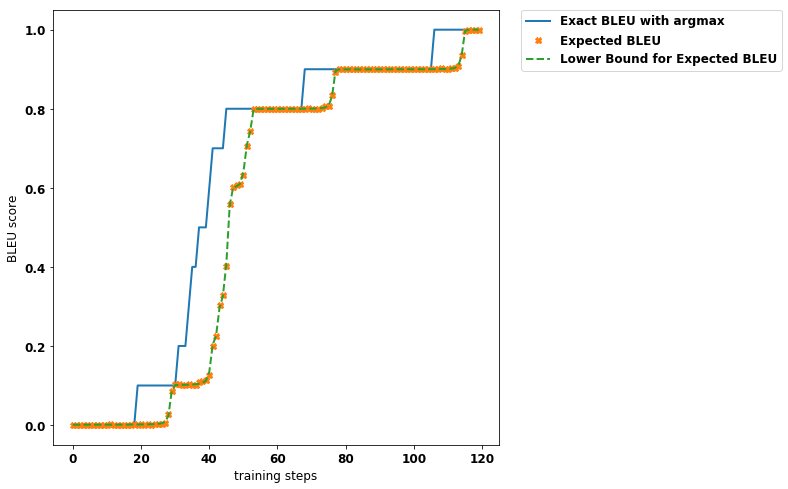

In [102]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
pylab.rcParams['figure.figsize'] = (8, 8)
plt.plot(bleus, '-', linewidth=2, label='Exact BLEU with argmax')
plt.plot(bst, 'X', linewidth=6, label='Expected BLEU')
plt.plot(res, '--', linewidth=2, label='Lower Bound for Expected BLEU')
plt.ylabel('BLEU score')
plt.xlabel('training steps')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [101]:
n_exp = 100
bs = []
bst = []
for p in probs:
    bs = []
    for i in range(n_exp):
        samples = []
        for l in range(length):
            samples.append(np.random.multinomial(1, p[l]-1e-10))
        text = np.array(samples).astype(np.float32)
        bs.append(bleu(Variable(torch.from_numpy(text)), r, f, 0.00001).data[0])
    bst.append(np.array(bs).mean())